In [1]:
# https://www.kaggle.com/c/house-prices-advanced-regression-techniques

%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, init,nd
from mxnet.gluon import loss as gloss, data as gdata, nn
import numpy as np
import pandas as pd

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

In [4]:
train_data.iloc[0:4, [0,1,2,3,4,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,WD,Normal,208500
1,2,20,RL,80.0,9600,WD,Normal,181500
2,3,60,RL,68.0,11250,WD,Normal,223500
3,4,70,RL,60.0,9550,WD,Abnorml,140000


In [5]:
all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:,1:]))
all_features.shape

(2919, 79)

In [6]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)
print(all_features[numeric_features].shape)

(2919, 36)


In [7]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [8]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1,1))
test_labels = nd.array(test)

In [9]:
# 训练模型

loss = gloss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

In [10]:
def log_rmse(net,features, labels):
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

In [17]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate':learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [12]:
def get_k_fold_data(k,i,X,y):
    assert k>1
    fold_size = X.shape[0]//k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        X_part,y_part = X[idx,:],y[idx]
        if j==i:
            X_vaild, y_vaild = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train,X_part, dim=0)
            y_train = nd.concat(y_train,y_part, dim=0)
    return X_train,y_train,X_vaild,y_vaild

In [15]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, vaild_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, vaild_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        vaild_l_sum += vaild_ls[-1]
        if i==0:
            d2l.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'rmse',
                        range(1, num_epochs+1), vaild_ls, ['train', 'vaild'])
        print('fold %d train rmse %f, vaild rmse %f'%(i, train_ls[-1], vaild_ls[-1]))
    return train_l_sum, vaild_l_sum

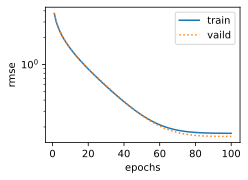

fold 0 train rmse 0.169682, vaild rmse 0.156703
fold 1 train rmse 0.162215, vaild rmse 0.189550
fold 2 train rmse 0.163448, vaild rmse 0.167891
fold 3 train rmse 0.167891, vaild rmse 0.154799
fold 4 train rmse 0.162897, vaild rmse 0.182739
5-fold vaildation: avg train rmse 0.826133, avg vaild rmse 0.851683


In [18]:
k, num_epochs, lr, weight_decay, batch_size= 5, 100, 5, 0, 64
train_l, vaild_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold vaildation: avg train rmse %f, avg vaild rmse %f'%(k,train_l,vaild_l))

In [37]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls,_ = train_ls, vaild_ls = train(net, train_features,train_labels,None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'rmse')
    print('train rmse: %f'%train_ls[-1])
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis = 1)
    submission.to_csv('submission.csv', index=False)

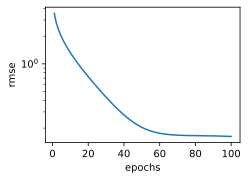

train rmse: 0.162374


In [38]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)